# Final Notebook 1: Food Access in LA County
## Group Members: Madi Hamilton, Jessica Fay, Meaghan Woody, Branden Bohrnsen
### UP221 Winter 2024

### Description
**Research Question:** Are there geographic disparities trends in food insecurity in Los Angeles County?

**Notebook purpose:** (1) Prepare data for mapping. (2) Descriptive analysis using plots and choropleth maps.

**Data sources:**
1. USC Neighborhood Data for Social Change
2. U.S. Census Bureau - American Community Survey 2016-2020
3. U.S. Census Tracts 2020
4. Grocery Store Walkability

### Import libraries

In [8]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from libpysal.weights import Queen
import esda
from esda.moran import Moran, Moran_Local
import contextily as ctx
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt
import plotly.express as px
from shapely import wkt
from shapely.wkt import loads
import branca.colormap as cm
import folium

import numpy as np
import networkx as nx
import contextily as cx
import osmnx as ox
import contextily as ctx
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import plotly.express as px
from sodapy import Socrata
import mapclassify
from shapely.geometry import Point
import seaborn as sns

### Import data

### Part 1 - Create merged dataset with variables and geometry

In [3]:
# Import merged dataset for USC and Census variables
food=pd.read_csv('finaldata_0303.csv')

# Load in tract shape file
tracts = gpd.read_file('tl_2020_06_tract.shp')
tracts['geoid20_x']=tracts.TRACTCE
tracts['COUNTYFP'].unique()

# Filter to LA County census tracts
latracts = tracts.query("COUNTYFP == '037'")

# Conditionally delete rows where hispanic % is outlier
new = food[food['% Hispanic or Latino'] <= 100]

# Merging the data
tracts_census= latracts.merge(new,on="geoid20_x")

# Export DataFrame to CSV
tracts_census.to_csv('merged_data_jf.csv', index=False)

#### Create new variables for analysis

In [4]:
# Create low access percent variable
a = food['lowaccess_count']
b =food['denom_total_pop']
food['lowaccess_pct']=round((a/b)*100)

# Create Food Insecurity Index 
# First, create a Natural Breaks classifier
classifier = mapclassify.NaturalBreaks.make(k=5)

# Age score
tracts_census['age_pct_score'] = tracts_census[['Percent 65 years and over']].apply(classifier)
tracts_census[['Percent 65 years and over', 'age_pct_score']].head()

# Hispanic score
tracts_census['hisp_pct_score'] = tracts_census[['% Hispanic or Latino']].apply(classifier)
tracts_census[['% Hispanic or Latino', 'hisp_pct_score']].head()

# Unemployment score
tracts_census['emp_pct_score'] = tracts_census[['% Unemployed']].apply(classifier)
tracts_census[['% Unemployed', 'emp_pct_score']].head()

# Food Insecurity Index: Age + Hispanic + Unemployment scores 
tracts_census['priority_index'] = tracts_census['age_pct_score']+tracts_census['hisp_pct_score']+tracts_census['emp_pct_score']

### Part 2 - Descriptive Analysis of Individual Variables

#### Not a Citizen

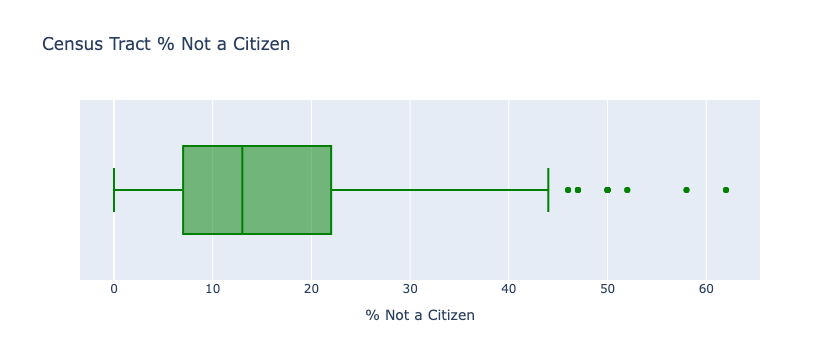

In [5]:
# Expolore demographics for Not a Citizen
# Create citizenship box plot (instead of scatterplot)
px.box(data_frame = new
       ,x = '% Not a Citizen', color_discrete_sequence = ['green'],title='Census Tract % Not a Citizen'
       )

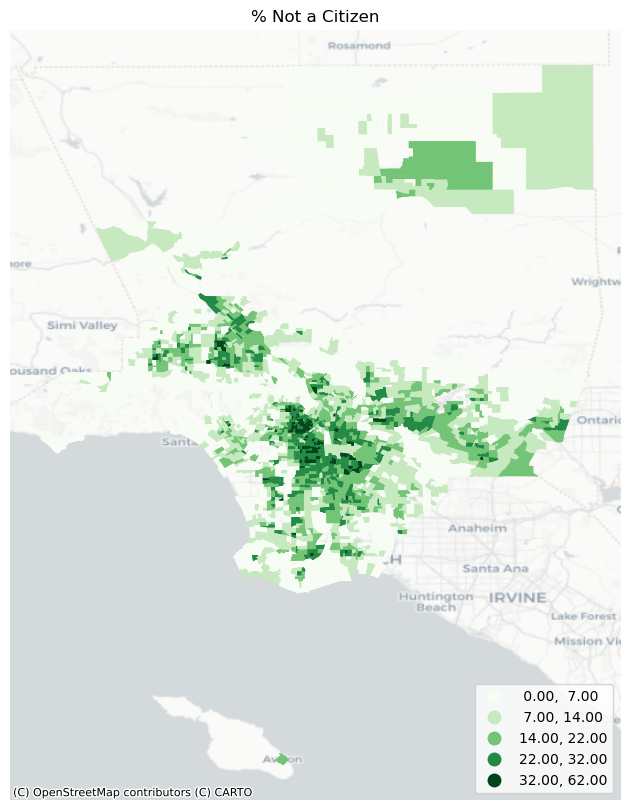

In [9]:
# Create citizenship map
ax = tracts_census.plot(figsize=(12,10),
                   column='% Not a Citizen',
                   legend=True,
                   scheme='NaturalBreaks',
                    cmap='Greens',
                 legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
ax.set_title('% Not a Citizen')
cx.add_basemap(ax,crs=4326,
               source=cx.providers.CartoDB.Positron)
plt.savefig('% Not a Citizen.png')

#### No Health Insurance

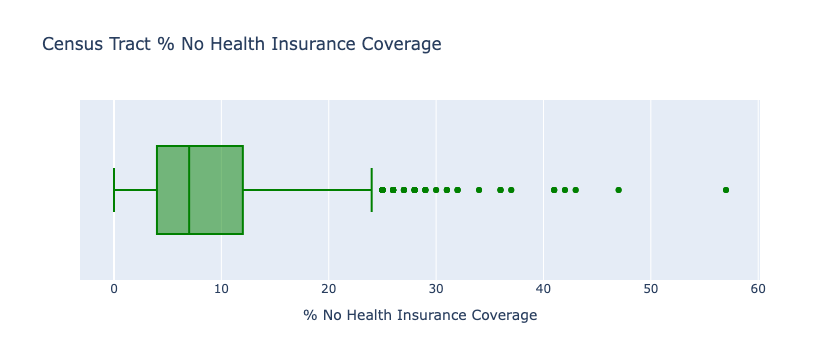

In [10]:
# Create box plot
px.box(data_frame = new
       ,x = '% No Health Insurance Coverage', color_discrete_sequence = ['green'],title='Census Tract % No Health Insurance Coverage'
       )

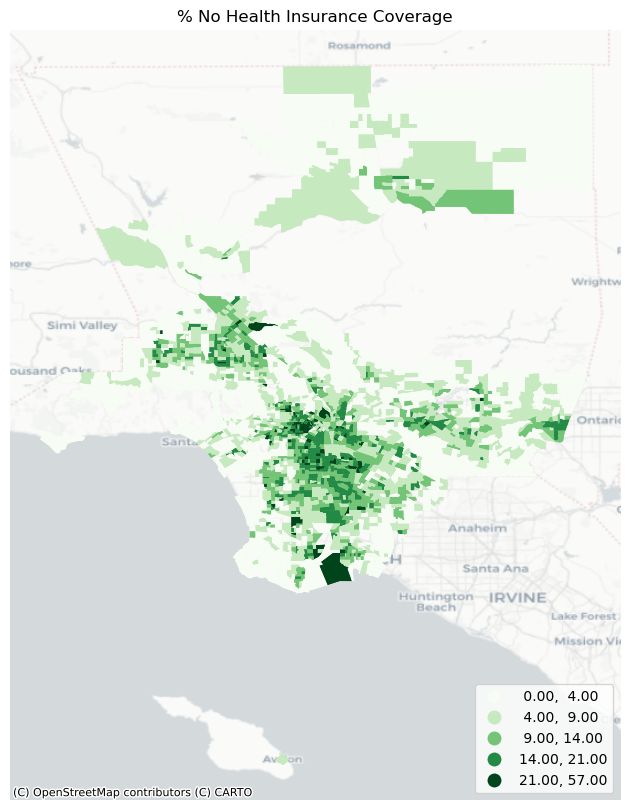

In [11]:
# Create Map
ax = tracts_census.plot(figsize=(12,10),
                   column='% No Health Insurance Coverage',
                   legend=True,
                   scheme='NaturalBreaks',
                    cmap='Greens',
             legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
ax.set_title('% No Health Insurance Coverage')
cx.add_basemap(ax,crs=4326,
               source=cx.providers.CartoDB.Positron)
plt.savefig('% No Health Insurance Coverage.png')

#### Median Household Income

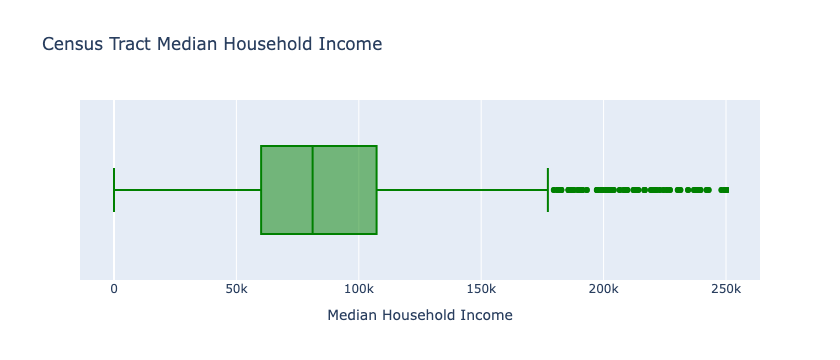

In [12]:
# explore distribution household income
px.box(data_frame = new
       ,x = 'Median Household Income', color_discrete_sequence = ['green'],title='Census Tract Median Household Income'
       )

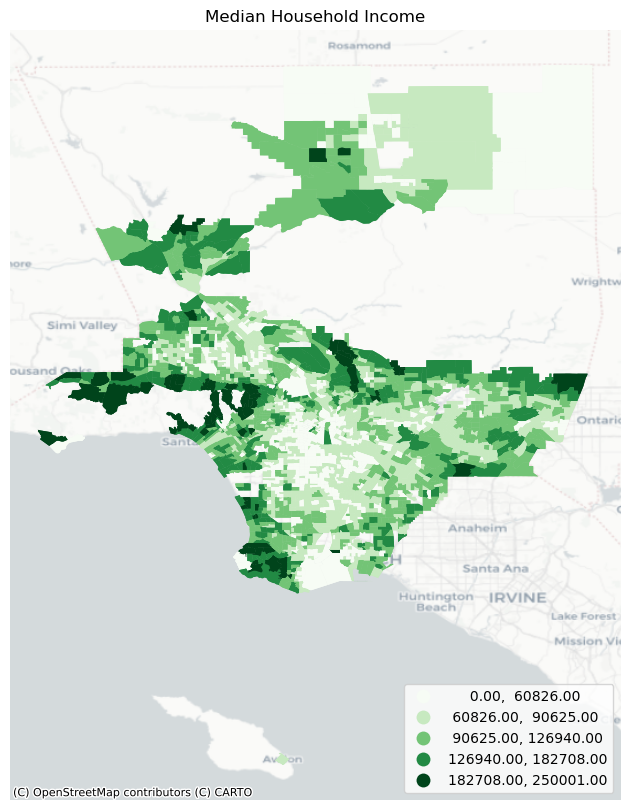

In [13]:
# Create map
ax = tracts_census.plot(figsize=(12,10),
                   column='Median Household Income',
                   legend=True,
                   scheme='NaturalBreaks',
                    cmap='Greens',
             legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
ax.set_title('Median Household Income')
cx.add_basemap(ax,crs=4326,
               source=cx.providers.CartoDB.Positron)
plt.savefig('Median Household Income')

#### Hispanic / Latino

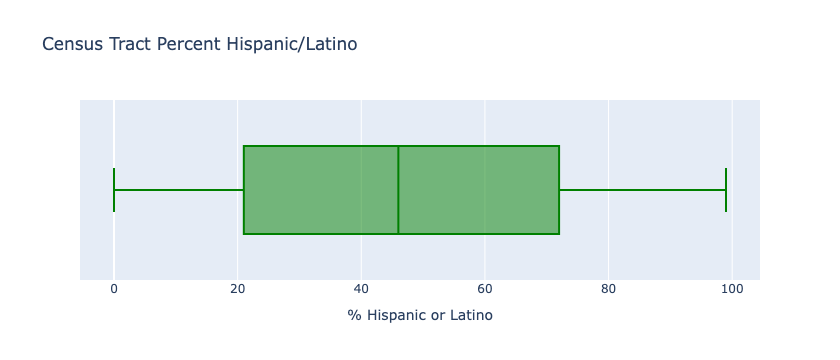

In [14]:
# explore distribution of Hispanic or Latino
px.box(data_frame = new
       ,x = '% Hispanic or Latino', color_discrete_sequence = ['green'],title='Census Tract Percent Hispanic/Latino'
       )

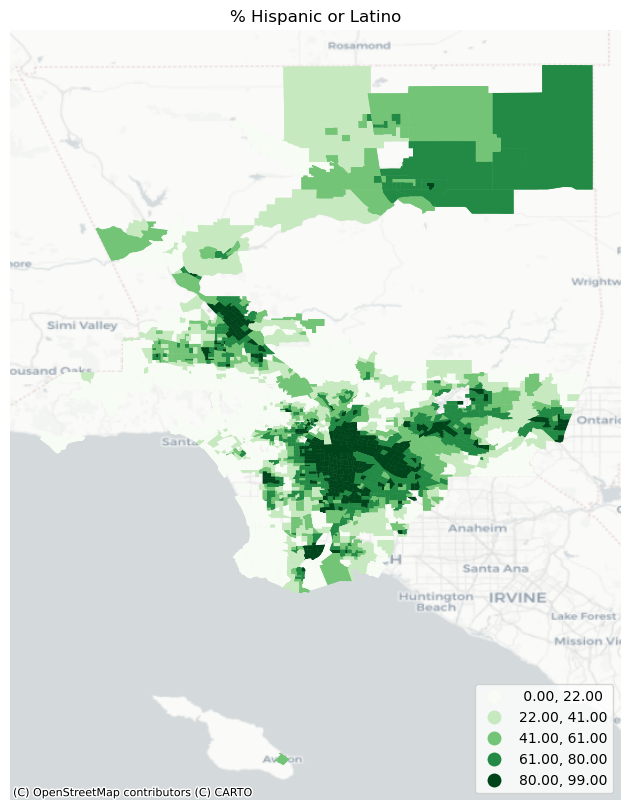

In [15]:
# Create map
ax = tracts_census.plot(figsize=(12,10),
                   column='% Hispanic or Latino',
                   legend=True,
                   scheme='NaturalBreaks',
                    cmap='Greens',
             legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
ax.set_title('% Hispanic or Latino')
cx.add_basemap(ax,crs=4326,
               source=cx.providers.CartoDB.Positron)
plt.savefig('% Hispanic or Latino.png')

#### Unemployment

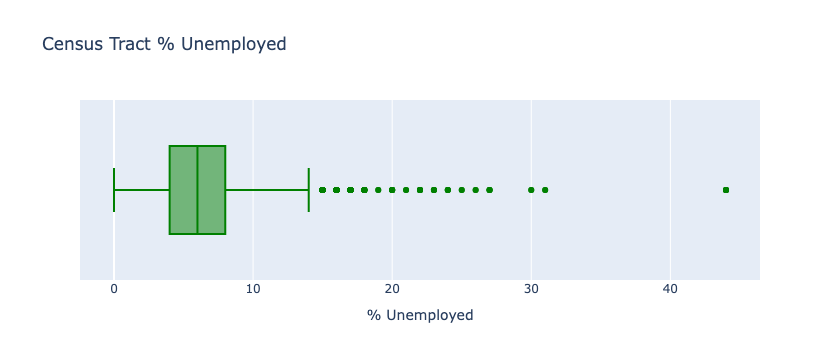

In [16]:
# Plot
px.box(data_frame = new
       ,x = '% Unemployed', color_discrete_sequence = ['green'],title='Census Tract % Unemployed'
       )

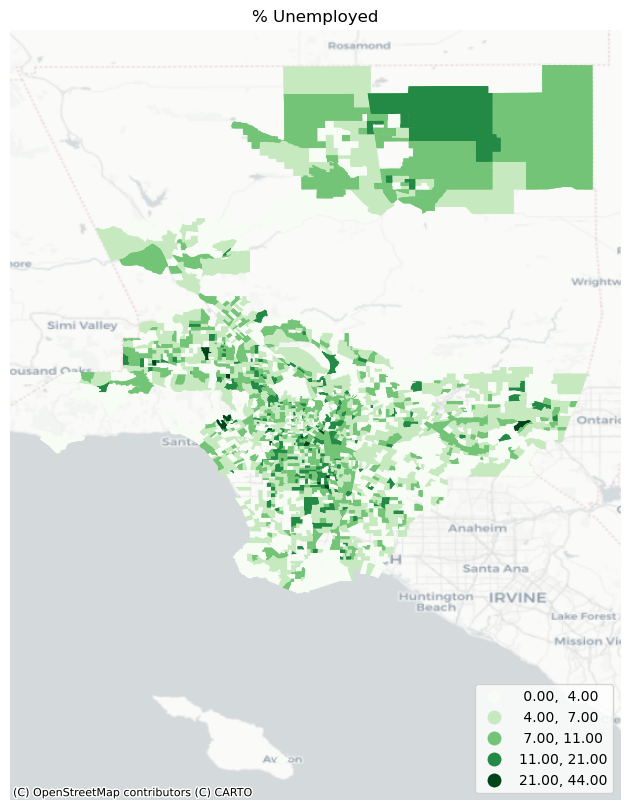

In [18]:
# Map
ax = tracts_census.plot(figsize=(12,10),
                   column='% Unemployed',
                   legend=True,
                   scheme='NaturalBreaks',
                    cmap='Greens',
             legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
ax.set_title('% Unemployed')
cx.add_basemap(ax,crs=4326,
               source=cx.providers.CartoDB.Positron)
plt.savefig('% Unemployed.png')

#### Education

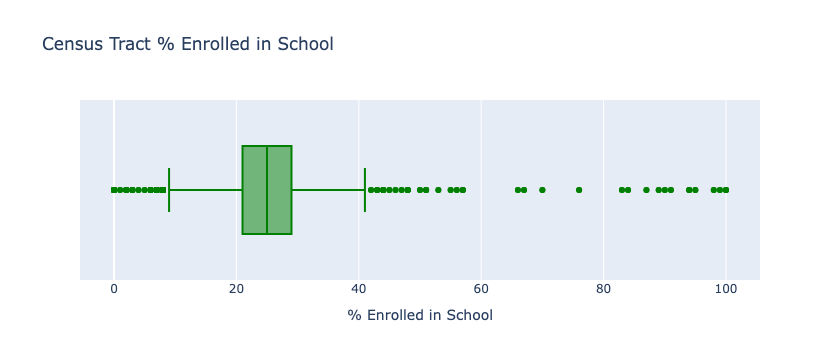

In [19]:
# exploreeducation
px.box(data_frame = new
       ,x = '% Enrolled in School', color_discrete_sequence = ['green'],title='Census Tract % Enrolled in School'
       )

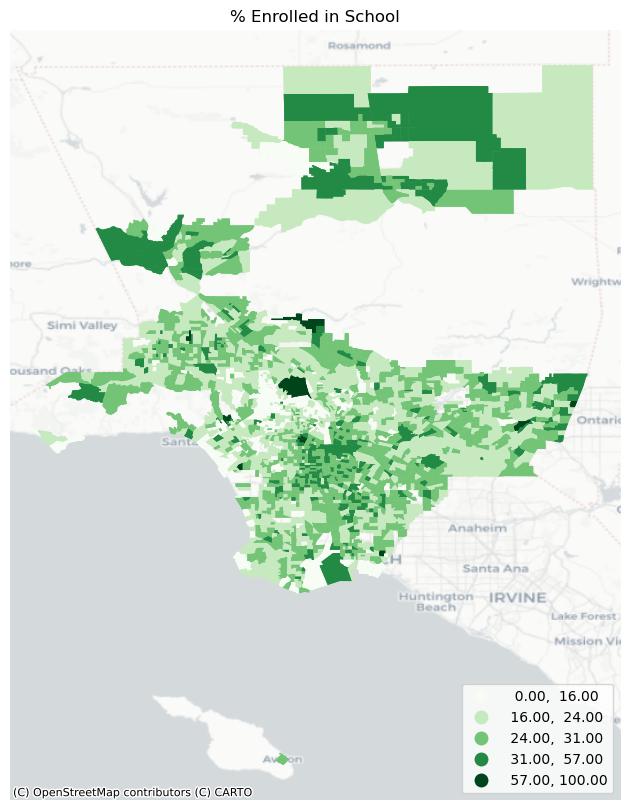

In [20]:
ax = tracts_census.plot(figsize=(12,10),
                   column='% Enrolled in School',
                   legend=True,
                   scheme='NaturalBreaks',
                    cmap='Greens',
             legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
ax.set_title('% Enrolled in School')
cx.add_basemap(ax,crs=4326,
               source=cx.providers.CartoDB.Positron)
plt.savefig('% Enrolled in School')

#### Older Age

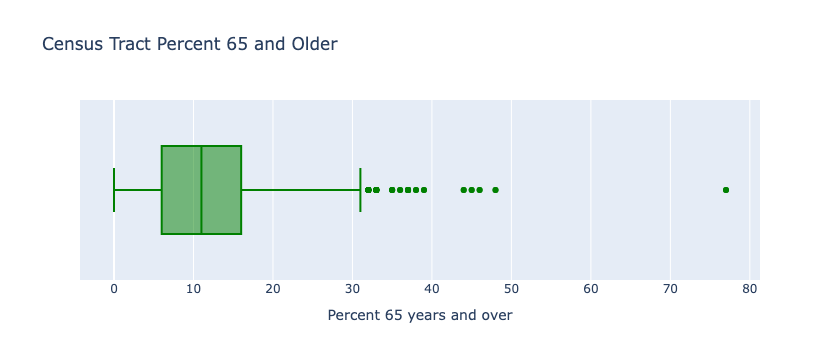

In [21]:
# explore distribution of percent > 65
px.box(data_frame = new
       ,x = 'Percent 65 years and over', color_discrete_sequence = ['green'], title='Census Tract Percent 65 and Older'
       )

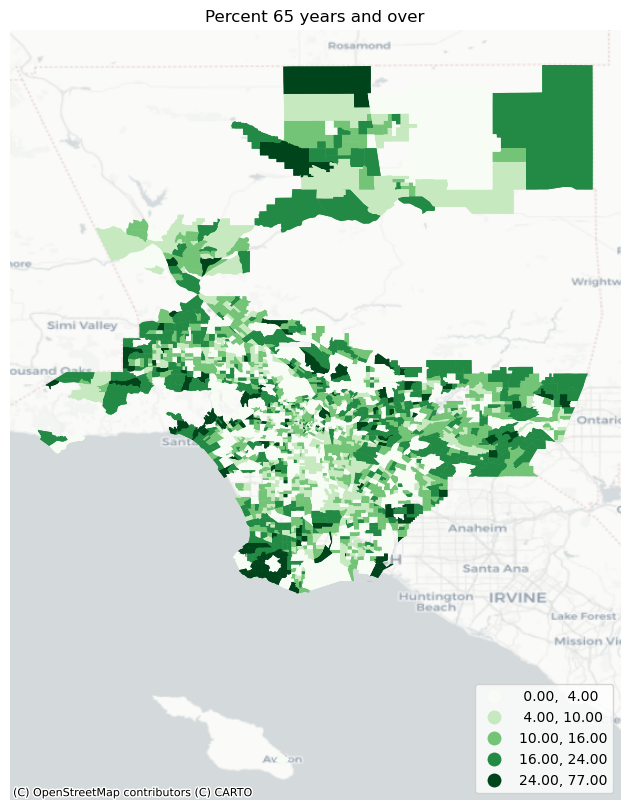

In [22]:
#% 65 and above
ax = tracts_census.plot(figsize=(12,10),
                   column='Percent 65 years and over',
                   legend=True,
                   scheme='NaturalBreaks',
                    cmap='Greens',
             legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
ax.set_title('Percent 65 years and over')
cx.add_basemap(ax,crs=4326,
               source=cx.providers.CartoDB.Positron)
plt.savefig('Percent 65 years and over.png')

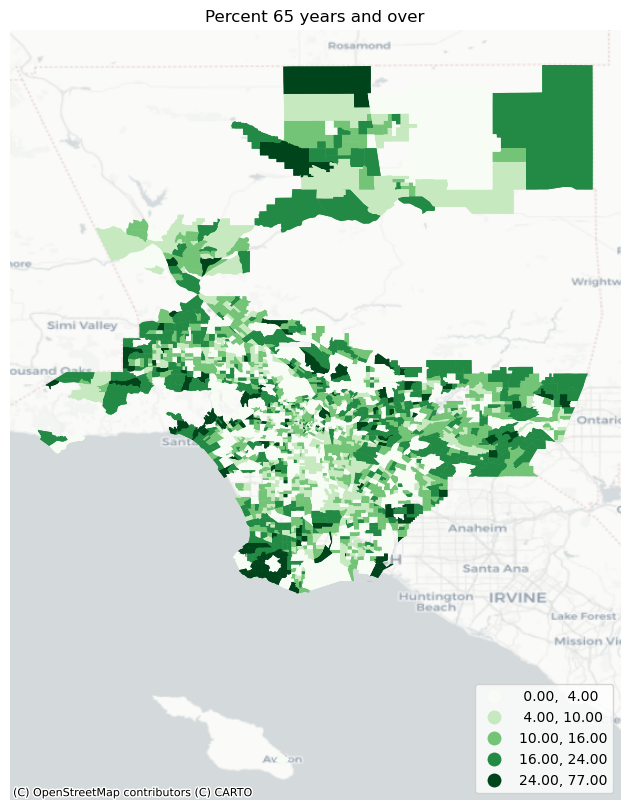

In [23]:
ax = tracts_census.plot(figsize=(12, 10),
              column='Percent 65 years and over',
              legend=True,
              scheme='NaturalBreaks',
              cmap='Greens',
              legend_kwds={'loc': 'lower right'})  # Specify legend location
ax.set_axis_off()
ax.set_title('Percent 65 years and over')
cx.add_basemap(ax, crs=4326, source=cx.providers.CartoDB.Positron)
plt.savefig('Percent 65 years and over.png')

#### Low Access to Grocery Stores

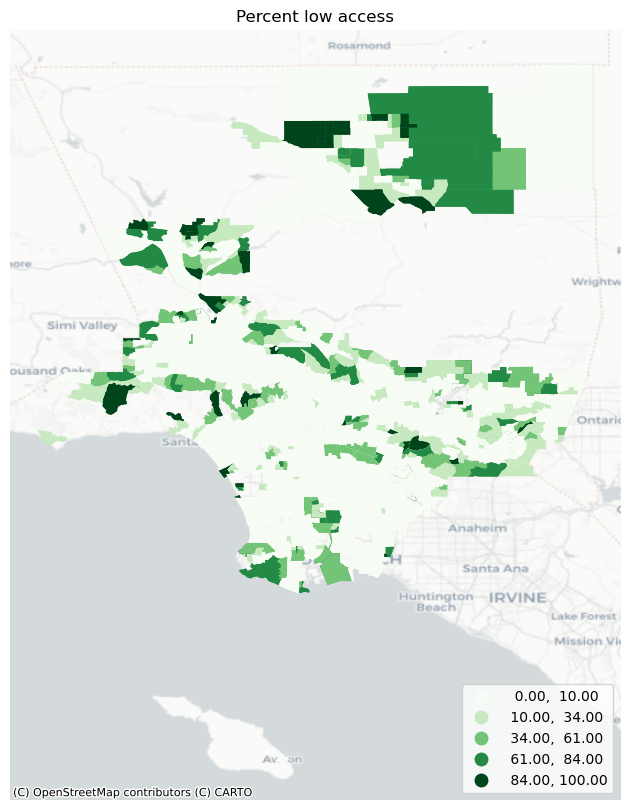

In [48]:
#create low access percent variable
a= gdf['lowaccess_count']
b=gdf['denom_total_pop']
gdf['lowaccess_pct']=round((a/b)*100)

#% low access
ax = gdf.plot(figsize=(12,10),
                   column='lowaccess_pct',
                   legend=True,
                   scheme='NaturalBreaks',
                    cmap='Greens',
             legend_kwds={'loc': 'lower right'})
ax.set_axis_off()
ax.set_title('Percent low access')
cx.add_basemap(ax,crs=4326,
               source=cx.providers.CartoDB.Positron)
plt.savefig('lowaccess_pct and over.png')

#### Food Insecurity Index

In [51]:
# Create Food Insecurity Index 
# Create a Natural Breaks classifier
classifier = mapclassify.NaturalBreaks.make(k=5)

# Age score
gdf['age_pct_score'] = gdf[['Percent 65 years and over']].apply(classifier)
gdf[['Percent 65 years and over', 'age_pct_score']].head()

# Hispanic score
gdf['hisp_pct_score'] = gdf[['% Hispanic or Latino']].apply(classifier)
gdf[['% Hispanic or Latino', 'hisp_pct_score']].head()

# Unemployment score
gdf['emp_pct_score'] = gdf[['% Unemployed']].apply(classifier)
gdf[['% Unemployed', 'emp_pct_score']].head()

# Food Index: Age + Hispanic + Unemployment scores 
gdf['priority_index'] = gdf['age_pct_score']+gdf['hisp_pct_score']+gdf['emp_pct_score']

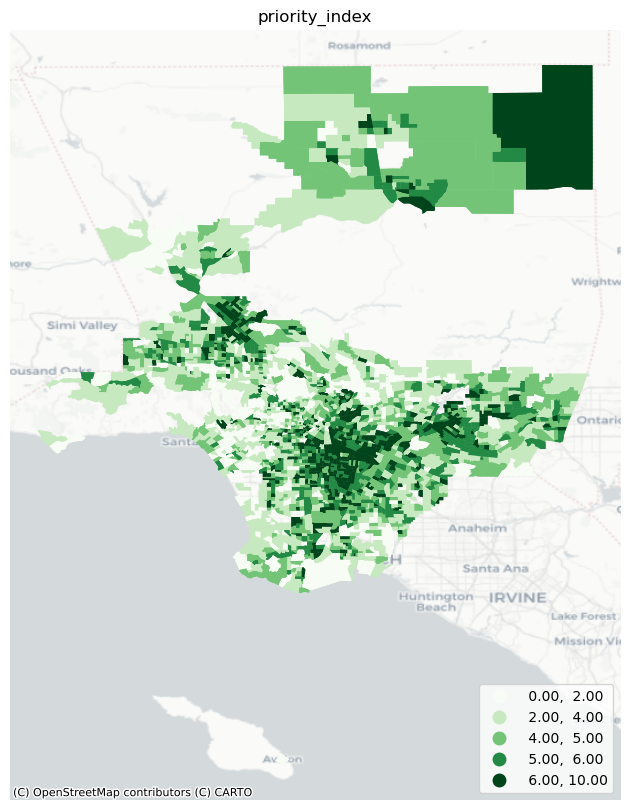

In [52]:
#FI index
ax = gdf.plot(figsize=(12,10),
                   column='priority_index',
                   legend=True,
                   scheme='NaturalBreaks',
                    cmap='Greens',
                    legend_kwds={'loc': 'lower right'})

ax.set_axis_off()
ax.set_title('Food Insecurity Index')
cx.add_basemap(ax,crs=4326,
               source=cx.providers.CartoDB.Positron)
plt.savefig('priority_index.png')